In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir('../notebook_format')
from formats import load_style
load_style()

In [2]:
os.chdir(path)
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 6 # change default figure size

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
%load_ext watermark
%load_ext autoreload 
%autoreload 2

import xgboost as xgb
from operator import itemgetter
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,xgboost,scikit-learn

Ethen 2016-08-04 08:45:22 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
xgboost 0.4a30
scikit-learn 0.17.1


# Which Customers are Happy Customers?

Kaggle's Santander Customer Satisfaction competition's [homepage](https://www.kaggle.com/c/santander-customer-satisfaction).

Customer satisfaction is a key measure of success. Unhappy customers don't stick around. What's more, unhappy customers rarely voice their dissatisfaction before leaving. Santander Bank is asking Kagglers to help them identify dissatisfied customers early in their relationship. Doing so would allow Santander to take proactive steps to improve a customer's happiness before it's too late. In this competition, you'll predict if a customer is satisfied or dissatisfied with their banking experience. 

You are provided with an anonymized dataset containing a large number of numeric variables. The "TARGET" column is the variable to predict. It equals 1 for unsatisfied customers and 0 for satisfied customers. The task is to predict the probability that each customer in the test set is an unsatisfied customer.

**Evaluation:** Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

**Submission File:** For each ID in the test set, you must predict a probability for the TARGET variable. The file should contain a header and have the following format:

```
ID,TARGET
2,0
5,0
6,0
```

To run the script please download the training and testing dataset from the competition webpage and store both of them in the same directory called `input`.

## Some Tricks Worth Noting

In [3]:
# DataFrame.isnull().any().any()
# with .isnull().any(), you can find just the columns that have NaN values,
# and another .any() indicates whether there're any missing values in the entire dataframe

# with DataFrame, 0 / 0 results in NaN, while some number / 0 results in +- inf
# remember to fix this in data preprocessing
df = pd.DataFrame({ "a": [ 1, 0, 0, 1, -5 ], "b": [ 0, 0, 20, 30, 0 ] })
df.a / df.b

0         inf
1         NaN
2    0.000000
3    0.033333
4        -inf
dtype: float64

## Starting

In [4]:
# create a submission directory
# all the predicted result's .csv file will be stored in it
dirs = 'submission'
if not os.path.exists(dirs):
    os.makedirs(dirs)

In [5]:
print('Loading data...')

train = pd.read_csv('input/train.csv')
test  = pd.read_csv('input/test.csv')
print( 'Initial data shape: {}'.format(train.shape) )

Loading data...
Initial data shape: (76020, 371)


In [6]:
# Check the distribution of the TARGET variable. 
# It's important to understand whether the data is balanced or not.
# The result tells us that a little less then 4% are unhappy and it is an unbalanced dataset
df_target = pd.DataFrame( train["TARGET"].value_counts() )
df_target["Percentage"] = 100 * df_target["TARGET"] / train.shape[0]
df_target

,TARGET,Percentage
0,73012,96.043147
1,3008,3.956853


In [7]:
print('Preprocessing data...')

# extract the output (target) and id column for both train and test
train_id = train['ID'].values
target = train['TARGET'].values
train = train.drop( [ 'ID', 'TARGET' ], axis = 1 )
test_id = test['ID'].values
test = test.drop( 'ID', axis = 1 )

# removing outliers and replacing it with mode
# 116 values in column var3 are -999999. This value suggests that the 
# column value for this customer is unknown and should be dealt with. 
# e.g. replace it with the mode of the column, which is 2. 
# In real world situations, it's better to consult with domain expert 
# and check the exact cause of this number.
outliers = -999999
mode = int( train['var3'].mode() )
train['var3'] = train['var3'].replace( outliers, mode )
test['var3']  = test['var3'].replace(  outliers, mode )

# add feature that counts the number of zeros in a row
train['zeroes'] = (train == 0).astype(int).sum( axis = 1 )
test['zeroes']  = (test  == 0).astype(int).sum( axis = 1 )

# remove constant columns where its standard deviation is 0 (value of each row is identical)
constant = [ col for col in train.columns if train[col].std() == 0 ]
train.drop( constant, axis = 1, inplace = True )
test.drop(  constant, axis = 1, inplace = True )
print( 'Data shape after removing constant columns: {}'.format(train.shape) )

# 1. remove duplicated columns (columns that have the exact same values),
#    keep only 1 of them. do not check for the ones that have been confirmed as not duplicates
# 2. cols are the columns that needs to be checked for duplicates
remove = []
cols = [ col for col in train.columns if col not in [ 'var3', 'var15', 'var38' ] ]
for i in range( len(cols) - 1 ):
    v = train[ cols[i] ].values
    for j in range( i + 1, len(cols) ):
        if np.array_equal( v, train[ cols[j] ].values ):
            remove.append(cols[j])

train.drop( remove, axis = 1, inplace = True )
test.drop(  remove, axis = 1, inplace = True )
print( 'Data shape after removing duplicated columns: {}'.format(train.shape) )

Preprocessing data...
Data shape after removing constant columns: (76020, 336)
Data shape after removing duplicated columns: (76020, 307)


In [8]:
# define xgboost parameters
# for complete list and detailed explanation
# http://xgboost.readthedocs.io/en/latest/parameter.html
xgb_params = {
    'eta': 0.1, # learning rate
    'objective': 'binary:logistic', # 'multi:softprob' for multi-class 
    'max_depth': 6, # length of the longest path from a root to a leaf
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing each tree
    'max_delta_step': 1, # setting it might help when class is extremely imbalanced
    'eval_metric': 'auc',
    'nthread': -1,
    'silent': 1
}

In [9]:
def retain_important_features( train, test, target, xgb_params ):
    """
    Pass in the DataFrame training, testing data; the target column
    and the dictionary that contains the parameters for the xgboost model
    to build the model, return the important features and predict the target column's
    probability. Note that the training and testing set's data type has to be the 
    same, or else xgboost's prediction might fail
    
    Returns
    -------
    train, test : DataFrame
        the training and testing data with only the important features retained, the 
        important features are calculated by the xgboost model
    
    imp_df : DataFrame with column name 'feature' and 'fscore'
        consists of the important feature and its relative importance score, note that
        only features with relative importance score about the mean are retained
    
    probs : 1d-array
        probability of the target, predicted by the xgboost model during the best round
    """
    
    # pass in the target class's column to perform stratified sampling,
    # which is preferred for unbalanced dataset, since the splitted folds are 
    # made by preserving the percentage of samples for each output class
    X_train, X_valid, y_train, y_valid = train_test_split( 
        train, # X
        target, # y
        test_size = 0.3,
        stratify = target
    )
    
    # check that the class's percentage in train and test are the same
    print( 'train class dist: {}'.format( np.bincount(y_train) / y_train.shape[0] ) )
    print( 'valid class dist: {}'.format( np.bincount(y_valid) / y_valid.shape[0] ) )
    
    # construct the DMatrix data structure used for xgboost,
    # and the watchlist that evaluates the training and testing,
    # this is used with early stopping that prevents the algorithm
    # from over-training the training set
    X_dtrain = xgb.DMatrix( X_train, label = y_train )
    X_dvalid = xgb.DMatrix( X_valid, label = y_valid )
    watchlist = [ ( X_dtrain, 'train' ), ( X_dvalid, 'test' ) ]

    xgb_model = xgb.train( 
        params = xgb_params, 
        dtrain = X_dtrain,
        num_boost_round = 300, # set it to a large number and let early stopping handle it
        evals = watchlist, 
        early_stopping_rounds = 3,
        verbose_eval = 10 # an evaluation metric is printed every specified number of boosting stages
    )
    
    # obtain the important variables calculated by the model
    # and re-compute its relative importance score
    importance = xgb_model.get_fscore()
    importance = sorted( importance.items(), key = itemgetter(1) )
    imp_df = pd.DataFrame( importance, columns = [ 'feature', 'fscore' ] ) 
    imp_df['fscore'] = imp_df['fscore'] / imp_df['fscore'].sum()
    
    # only retain the variables that are higher than
    # the mean relative importance score (you can change the threshold)
    # you can easily tune the cutoff with the quantile
    imp_df = imp_df[ imp_df['fscore'] >= imp_df['fscore'].quantile(0.5) ]
    imp_cols = imp_df['feature'].values.tolist()
    
    # predict the entire test set
    # If early stopping is enabled during training, 
    # you can get predicticions from the best iteration by setting 
    # the specifying the ntree_limit = .best_ntree_limit
    dtest = xgb.DMatrix(test)
    probs = xgb_model.predict( dtest, ntree_limit = xgb_model.best_ntree_limit )
        
    return train[imp_cols], test[imp_cols], imp_df, probs

In [10]:
# train the model for the first time
train1, test1, imp_df1, probs1 = retain_important_features( 
    train = train, 
    test = test,
    target = target, 
    xgb_params = xgb_params
)

train class dist: [ 0.96042395  0.03957605]
valid class dist: [ 0.960449  0.039551]


Will train until test error hasn't decreased in 3 rounds.
[0]	train-auc:0.503740	test-auc:0.502635
[10]	train-auc:0.725146	test-auc:0.706908
[20]	train-auc:0.837847	test-auc:0.814148
Stopping. Best iteration:
[25]	train-auc:0.855341	test-auc:0.825456



In [11]:
print(train1.shape)

# auc 0.806928
submission1 = pd.DataFrame({ 'ID': test_id, 'TARGET': probs1 })
submission1.to_csv( os.path.join( dirs, 'submission1.csv' ), index = False )

(76020, 45)


In [12]:
# randomly generate interaction between all feature combinations
# here, it is done by subtracting the first column with the second
# and divide it with the first (you can try other interactions),
# not a good idea in real world application
train_col_len = len(train1.columns)

for i in range(train_col_len):
    col1 = train1.columns[i]    
    
    for j in range(train_col_len):        
        col2 = train1.columns[j]
        col_name = col1 + '_SUBTRACT_' + col2 + '_DIVIDE_' + col1
        train1[col_name] = ( train1[col1] - train1[col2] ) / train1[col1]
        test1[col_name]  = ( test1[col1] - test1[col2] ) / test1[col1]

In [13]:
# replace the nan and inf generated from the manual interaction
# with numbers specifying different conditions (how they were generated)
train1 = train1.replace( np.inf, 999999 )
train1 = train1.replace( -np.inf, -999999 )
train1 = train1.replace( np.nan, -1 )
test1  = test1.replace( np.inf, 999999 )
test1  = test1.replace( -np.inf, -999999 )
test1  = test1.replace( np.nan, -1 )
print( 'Data shape after randomly generating interations: {}'.format(train1.shape) )

Data shape after randomly generating interations: (76020, 2070)


In [14]:
# include the interaction and train the model for the second time
train2, test2, imp_df2, probs2 = retain_important_features( 
    train = train1, 
    test = test1, 
    target = target, 
    xgb_params = xgb_params
)

train class dist: [ 0.96042395  0.03957605]
valid class dist: [ 0.960449  0.039551]


Will train until test error hasn't decreased in 3 rounds.
[0]	train-auc:0.507234	test-auc:0.501343
[10]	train-auc:0.616221	test-auc:0.606890
[20]	train-auc:0.851380	test-auc:0.817330
[30]	train-auc:0.876209	test-auc:0.834318
Stopping. Best iteration:
[34]	train-auc:0.881701	test-auc:0.835357



In [15]:
print(train2.shape)

# auc 0.820486
submission2 = pd.DataFrame({ 'ID': test_id, 'TARGET': probs2 })
submission2.to_csv( os.path.join( dirs, 'submission2.csv' ), index = False )

(76020, 561)


In [16]:
def write_preprocessed_data( train, test, target, train_id, test_id ):
    """
    usually a good idea to store the preprocessed data,
    add the TARGET and ID column back
    """
    
    # copy the train and test to avoid overwriting the original one,
    # in case you simply want to write it out and still want to continue to 
    # perform other actions 
    train_copy = train.copy()
    test_copy  = test.copy()
    
    train_copy['TARGET'] = target
    train_copy['ID'] = train_id
    test_copy['ID'] = test_id

    train_copy.to_csv( "df_train.csv", index = False )
    test_copy.to_csv(  "df_test.csv" , index = False )

In [17]:
write_preprocessed_data( 
    train = train2, 
    test = test2, 
    target = target, 
    train_id = train_id, 
    test_id = test_id
)

In [18]:
# xgboost's cross validation currently does not return a model according to
# https://github.com/dmlc/xgboost/pull/1156
def xgboost_cv( train, test, target, n_folds, xgb_params ):
    """
    xgboost cross validation with stratified k-fold;
    pass in the DataFrame training and testing set; target column;
    number of folds used for cross validation; and the dictionary
    that holds the parameter for xgboost.
    during the training process, the auc score for each fold is printed
    
    Returns
    -------
    xgb_models : list
        stores the xgboost model for each fold
        
    cv_auc : float
        cross validated auc score
        
    test_pred : 1d-array
        predicted target probability of the test set
    """

    predicted_result = np.zeros(train.shape[0]) # prediction on the out of fold sample
    test_pred  = [] # stores the predicted probability of the test set
    xgb_models = [] # stores each fold's xgb model
    dtest = xgb.DMatrix(test.values)
    
    skf = StratifiedKFold( y = target, n_folds = n_folds )
    for idx, ( train_idx, test_idx ) in enumerate(skf):

        train_fold, test_fold = train.values[train_idx], train.values[test_idx]
        train_target, test_target = target[train_idx], target[test_idx]
        dtrain_fold = xgb.DMatrix( train_fold, label = train_target ) 
        
        # without early stopping, this takes too long consider the size of
        # of data is still really small
        xgb_fold = xgb.train( 
            params = xgb_params, 
            dtrain = dtrain_fold, 
            num_boost_round = 100  
        )
        xgb_models.append(xgb_fold)

        # only predict the folded test set
        dtest_fold = xgb.DMatrix(test_fold)
        xgb_pred = xgb_fold.predict( dtest_fold, ntree_limit = xgb_fold.best_ntree_limit )    
        predicted_result[test_idx] = xgb_pred
        fold_auc = roc_auc_score( y_true = test_target, y_score = xgb_pred )
        print( 'auc for fold {}: {}'.format( idx + 1, fold_auc ) )

        # predict the entire test set
        test_pred.append( xgb_fold.predict( dtest, ntree_limit = xgb_fold.best_ntree_limit ) )
    
    # the final reported predicted probability is the average of all folds
    test_pred = np.average( np.array(test_pred), axis = 0 )
    
    # report the out-of-fold sample's score
    cv_auc = roc_auc_score( y_true = target, y_score = predicted_result )

    return xgb_models, cv_auc, test_pred

In [19]:
# decrease the learning rate eta;
# subsample: subsample ratio of rows to fit the model
updated_params = {
    'eta': 0.02,
    'colsample_bytree': 0.7,
    'subsample': 0.7
}
xgb_params.update(updated_params)
xgb_params

{'colsample_bytree': 0.7,
 'eta': 0.02,
 'eval_metric': 'auc',
 'max_delta_step': 1,
 'max_depth': 6,
 'nthread': -1,
 'objective': 'binary:logistic',
 'silent': 1,
 'subsample': 0.7}

In [20]:
xgb_models, cv_auc, test_pred = xgboost_cv( 
    train = train2, 
    test = test2, 
    target = target, 
    n_folds = 10,
    xgb_params = xgb_params
)

auc for fold 0: 0.8307217519252451
auc for fold 1: 0.8345786117852387
auc for fold 2: 0.8172354763216798
auc for fold 3: 0.8354173482811484
auc for fold 4: 0.8409597556608319
auc for fold 5: 0.8387707777708511
auc for fold 6: 0.8509729473184622
auc for fold 7: 0.8608139057089982
auc for fold 8: 0.8587250604939962
auc for fold 9: 0.8246183171255079


In [21]:
# auc 0.823068
print(cv_auc)
submission_cv = pd.DataFrame({ "ID": test_id, "TARGET": test_pred })
submission_cv.to_csv( os.path.join( dirs, 'submission_cv.csv' ), index = False )

0.838307665615


## Others

In [22]:
# 1. saving and loading the DMatrix data structure
# dtest.save_binary('dtest.buffer')
# dtest2 = xgb.DMatrix('dtest.buffer')

# 2. saving and loading the model
# xgb_model.save_model("xgb.model")
# xgb2 = xgb.Booster( model_file = "xgb.model" ) 

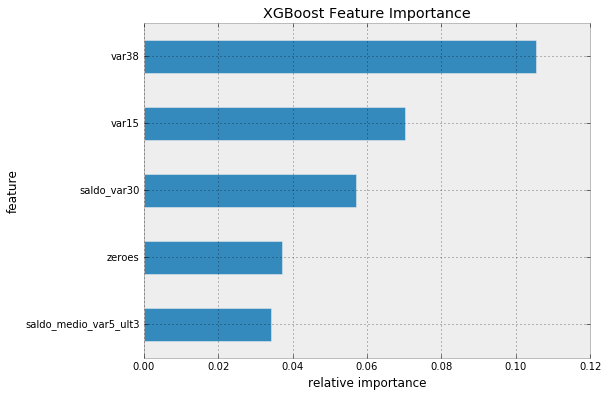

In [23]:
# you can plot the feature importance score,
# note that in this script, the score is sorted in increasing order,
# so to plot the top 5 important feauture, you'll have to obtain the last 5 row
imp_df1.iloc[-5:].plot( kind = 'barh', x = 'feature', y = 'fscore', legend = False, figsize = ( 8, 6 ) )
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

## Future Work

1. This this is an unbalanced dataset, it's worth trying out under/over sampling techniques.
2. Perform grid search/random search to find the "best" parameters for xgboost.
3. Find a better workflow for cross validation on xgboost.
4. Perform standardization, and try out deep learning. Standardizing features by removing the mean and scaling to unit variance is not needed for tree-type algorithms, but required for other types of algorithms ( e.g. deeplearning, svm, regression ).
    
```python

from sklearn.preprocessing import StandardScaler

# standardize
std = StandardScaler()
train_std = std.fit_transform(train)
test_std  = std.transform(test)

# convert the standardized features from np.array back to DataFrame
train = pd.DataFrame( train_std, columns = train.columns )
test  = pd.DataFrame( test_std , columns = test.columns )

```